In [1]:
package_paths = [r"C:\Users\benja\Documents\projects\goalscorers"]
import sys
for path in package_paths:
    sys.path.append(path)
import goalscorer_package.constants as c
import goalscorer_package.data_cleaning as dc
import goalscorer_package.modelling as m
import datetime as dt
import pandas as pd
import numpy as np
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")
import arviz as az
print(f"Running on Az v{az.__version__}")
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
from statistics import mode
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.options.display.float_format = "{: ,.3f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_formats = ["retina"]

Running on PyMC v5.6.1
Running on Az v0.16.0


# Model description

$$
X_{i, k} \sim \text{Poisson}(\lambda=\lambda_{i, k})  \\  
$$
$$
\lambda_{i, k} = \text{exp}(F_i) * npxG_{i, k}  \\  
$$

Where:  
$k$ - match  
$i$ - player  
  
$X$ - non-penalty goals  
$F$ - player ability to score above xG (finishing skill)  
$npxG$ - non-penalty expected goals  

# Data

In [2]:
seasons = ["2020-2021"]
comp_ids = [9, 10, 11]

In [3]:
def data(seasons: list[str], comp_ids: list[int]) -> pd.DataFrame:
    seasons_leagues = dc.get_seasons_leagues_from_str(seasons, comp_ids)
    df = dc.load_seasons_leagues_files("summary", True, seasons_leagues)
    df = dc.split_positions(df)
    df = dc.position_to_generic_position(df)
    df = dc.add_frac_90(df)
    df = dc.add_home(df)
    df = dc.add_opp_team(df)
    df = dc.drop_gk(df)
    df = dc.drop_na_npxg(df)
    df = dc.add_league(df)
    df = dc.add_npg(df)
    df["league_10"] = np.where((df.league == 10), 1, 0)
    df.npxg = np.where((df.npg != 0) & (df.npxg == 0), 0.03, df.npg)  # npxg gets rounded to 0, but a non-penalty goal is scored
    return df

In [4]:
df = data(seasons, comp_ids)

In [5]:
df_model = df[["npg", "npxg", "player_id", "position"]].copy()
df_model.head()

npg   npxg player_id position
0    0  0.000  4047c976       FW
1    0  0.000  3925dbd6       FW
2    0  0.000  979b811d        W
3    0  0.000  18b999f4        W
4    0  0.000  6bb2c084        W

# Model

## Priors

In [6]:
player_id_codes, player_ids = pd.factorize(df_model.loc[:, "player_id"], sort=True)

coords = {"player_ids": player_ids}

In [7]:
df_player_priors = (
    df
    .groupby(["player_id"], as_index=False)
    .agg(position=("position", mode))
    .assign(mu=0.0, sigma=0.13)
)
df_player_priors.index = df_player_priors.player_id
df_player_priors = df_player_priors.loc[player_ids]

## Fit

In [8]:
with pm.Model(coords=coords) as model:
    # Data
    player_id_codes_data = pm.MutableData("player_id_codes_data", player_id_codes)
    npxg_data = pm.MutableData("npxg_data", df_model.npxg.values)
    npg_data = pm.MutableData("npg_data", df_model.npg.values)

    # Priors
    F = pm.Normal("F", mu=df_player_priors.mu.values, sigma=df_player_priors.sigma.values, dims="player_ids")

    # Deterministic transform
    exp = pm.Deterministic("exp", npxg_data * pt.exp(F[player_id_codes_data]))

    # Likelihood
    x = pm.Poisson(
        "x",
        mu=exp,
        observed=npg_data
    )

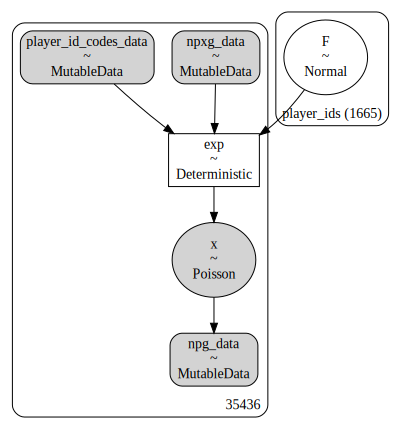

In [9]:
pm.model_to_graphviz(model)

### Prior Predictive

In [10]:
with model:
    prior = pm.sample_prior_predictive(samples=1000)

Sampling: [F, x]


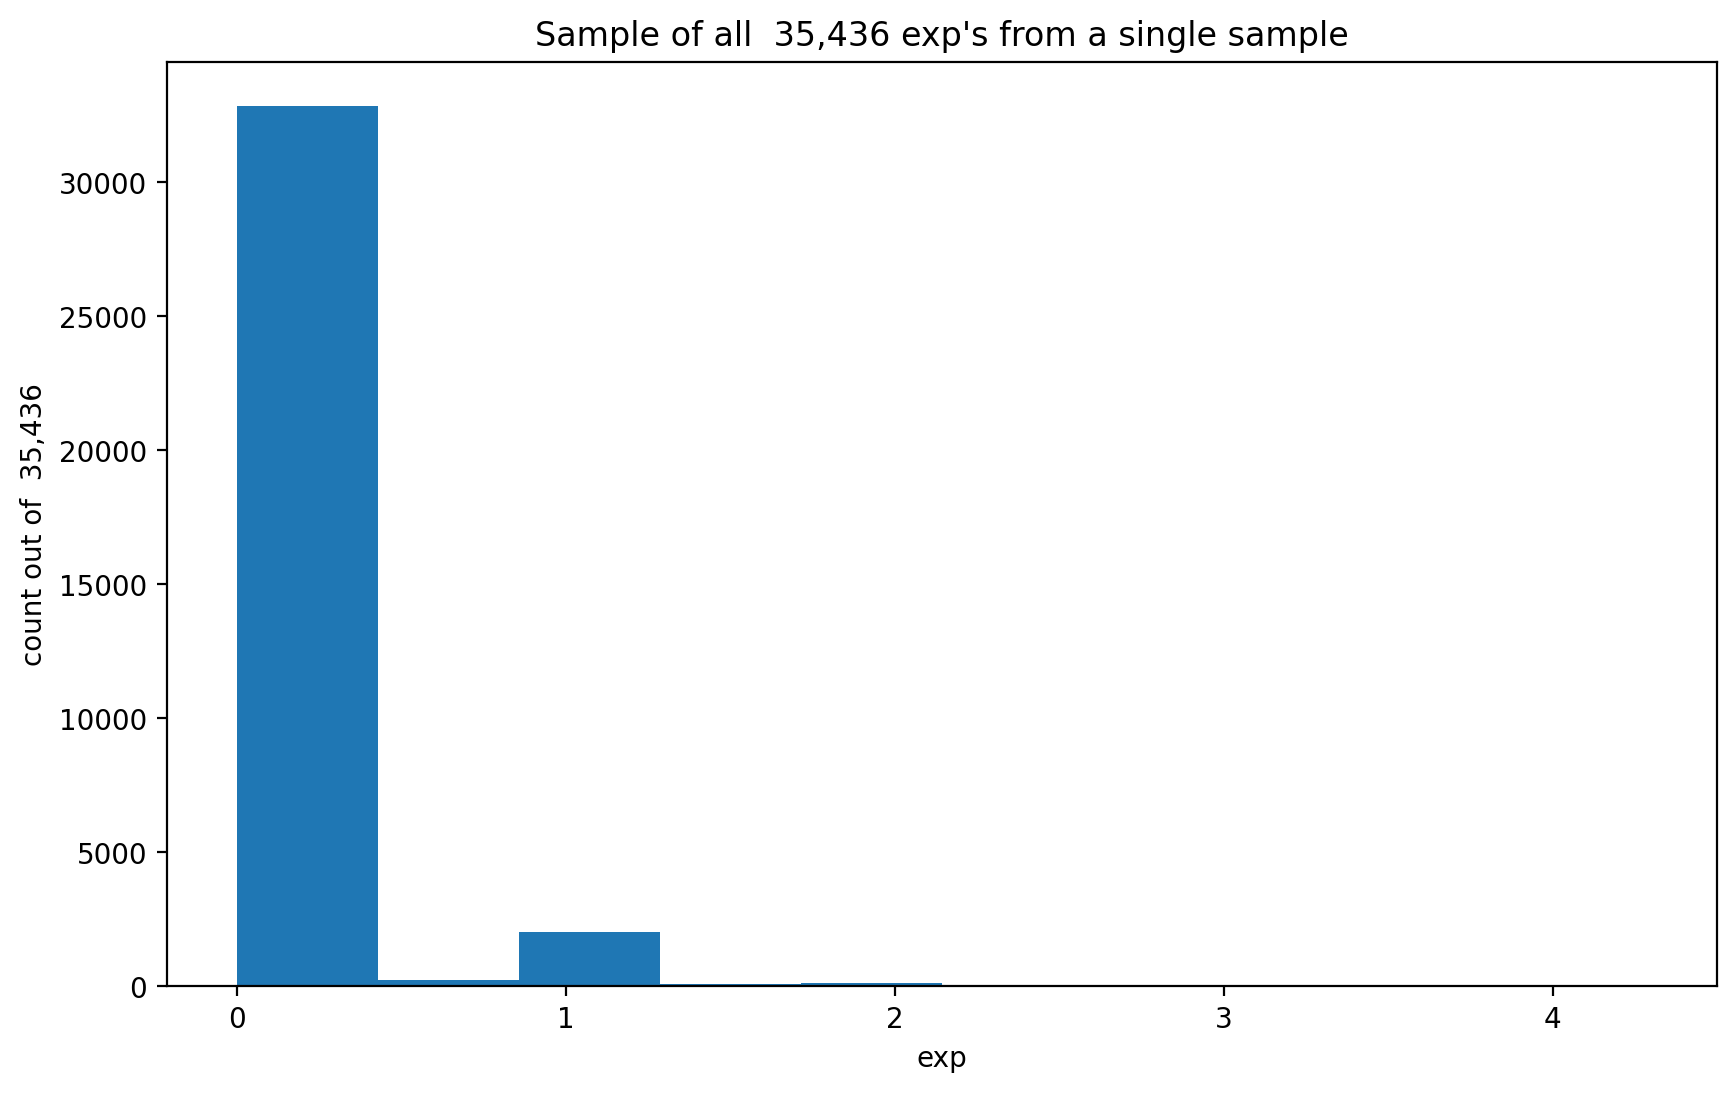

In [11]:
# sample of all eta's form a single sim

plt.hist(prior.prior.exp.sel(chain=0, draw=0).data)
plt.title(f"Sample of all {len(df_model): ,} exp's from a single sample")
plt.xlabel("exp")
plt.ylabel(f"count out of {len(df_model): ,}");

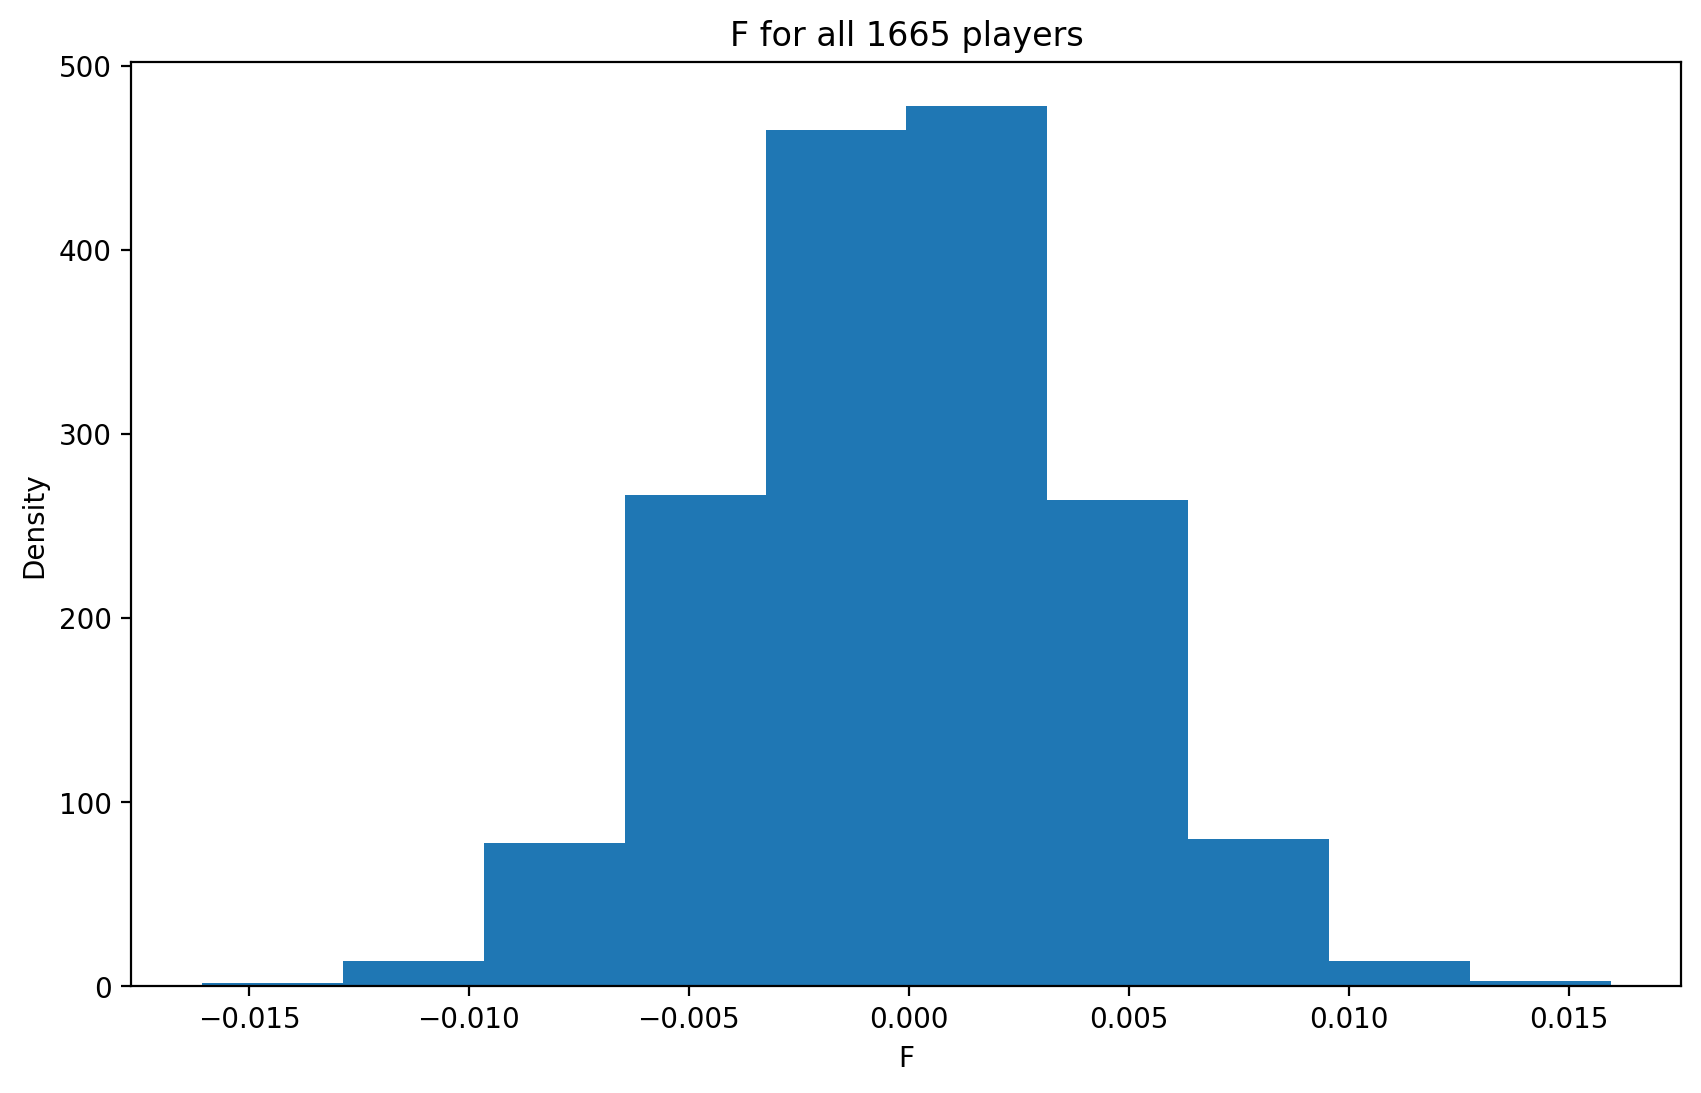

In [13]:
plt.hist([prior.prior.F.sel(player_ids=player_id).data.mean() for player_id in player_ids])
plt.title(f"F for all {len(player_ids)} players")
plt.xlabel("F")
plt.ylabel("Density");

### Sample

In [14]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [F]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 232 seconds.


### MCMC Diagnostics

R-hat value < 1.1 => Good

In [15]:
az.summary(idata, var_names=["F"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
F[003a5c72] -0.000  0.130  -0.254    0.235      0.001    0.003   8,335.000   
F[007b39a5]  0.001  0.124  -0.213    0.253      0.001    0.002   8,074.000   
F[008a6e6d]  0.001  0.131  -0.249    0.244      0.001    0.002   9,755.000   
F[008f854b] -0.002  0.125  -0.234    0.232      0.001    0.002   8,142.000   
F[00ddb7f7]  0.001  0.130  -0.229    0.243      0.001    0.002   7,824.000   
...            ...    ...     ...      ...        ...      ...         ...   
F[ff527768]  0.000  0.132  -0.248    0.245      0.001    0.003   8,463.000   
F[ff800ed8] -0.000  0.130  -0.251    0.238      0.001    0.002   9,443.000   
F[ff9fcd4d]  0.001  0.130  -0.230    0.240      0.001    0.003  10,763.000   
F[ffa90327]  0.000  0.127  -0.235    0.248      0.001    0.002   7,286.000   
F[ffec9769] -0.000  0.133  -0.241    0.257      0.001    0.003   9,789.000   

              ess_tail  r_hat  
F[003a5c72]  2,323.000  1.000  
F[007b39a5]  2,970.000  1.000  
F[008a6e6d]  2,738.000  1.000  
F[008f854b]  2,721.000  1.000  
F[00ddb7f7]  2,591.000  1.000  
...                ...    ...  
F[ff527768]  2,282.000  1.000  
F[ff800ed8]  2,849.000  1.000  
F[ff9fcd4d]  2,568.000  1.000  
F[ffa90327]  2,642.000  1.000  
F[ffec9769]  2,505.000  1.000  

[1665 rows x 9 columns]

array([[<Axes: title={'center': 'F'}>, <Axes: title={'center': 'F'}>]],
      dtype=object)

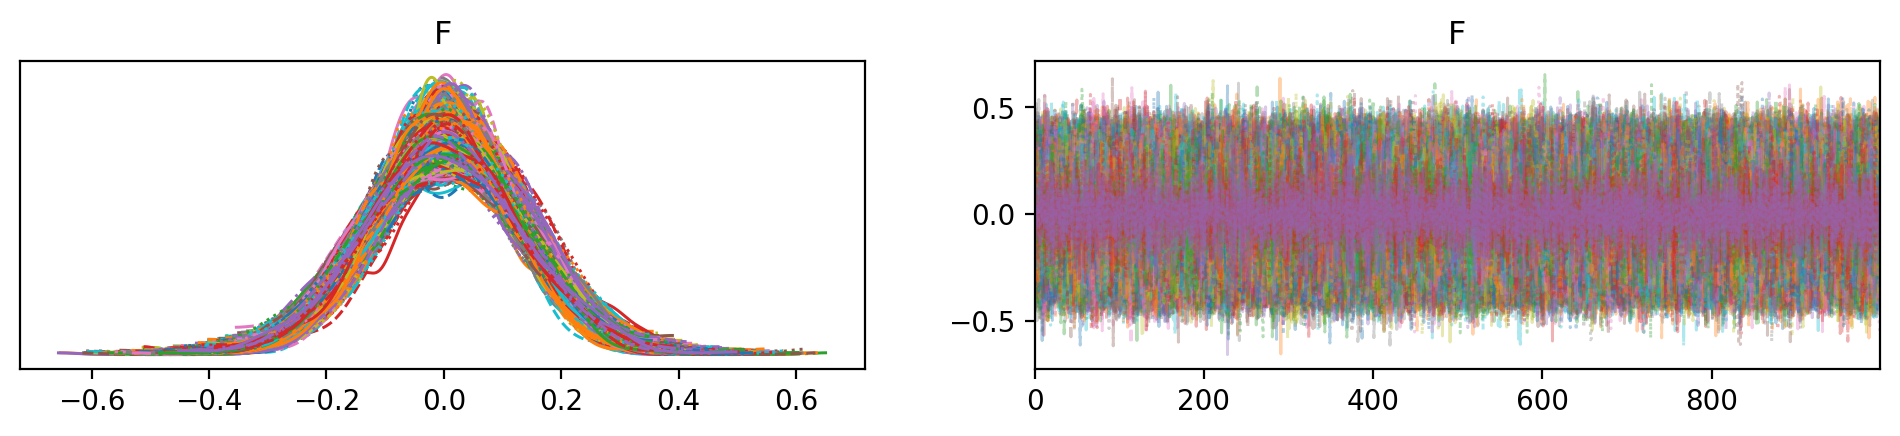

In [16]:
az.plot_trace(idata, var_names=["F"])

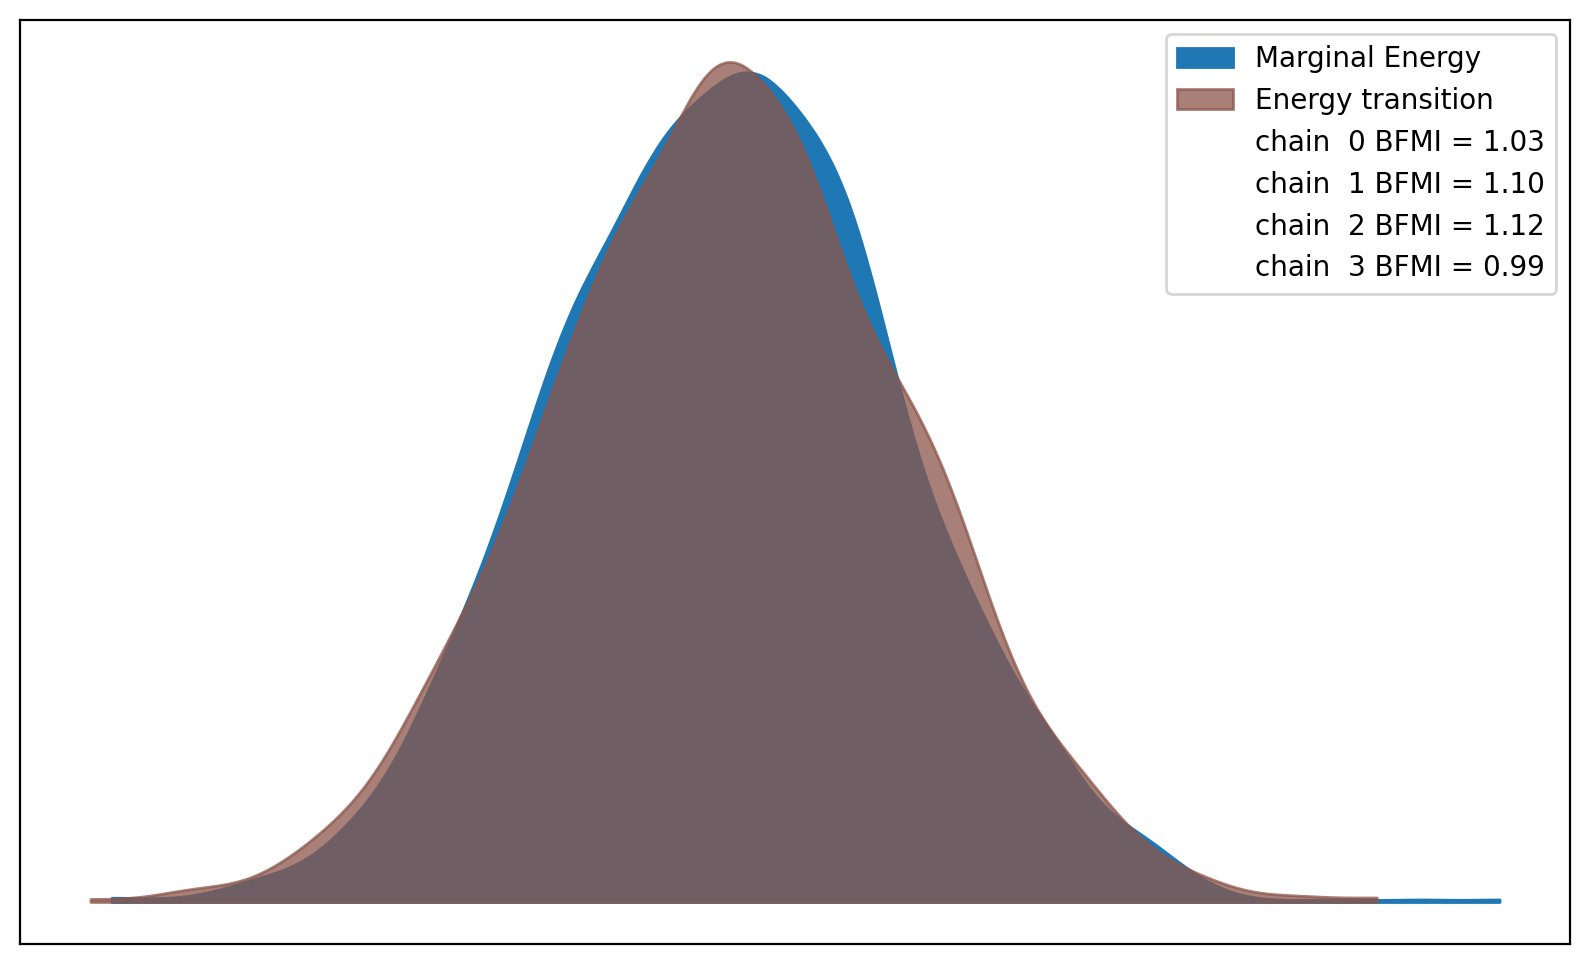

In [17]:
az.plot_energy(idata);

### Model Parameters

In [18]:
az.plot_posterior(idata, var_names=["F"]);

C:\Users\benja\anaconda3\envs\pymc_env_2\Lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1665) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'F\n003a5c72'}>,
        <Axes: title={'center': 'F\n007b39a5'}>,
        <Axes: title={'center': 'F\n008a6e6d'}>,
        <Axes: title={'center': 'F\n008f854b'}>],
       [<Axes: title={'center': 'F\n00ddb7f7'}>,
        <Axes: title={'center': 'F\n00e1cf8f'}>,
        <Axes: title={'center': 'F\n00f0482f'}>,
        <Axes: title={'center': 'F\n01040647'}>],
       [<Axes: title={'center': 'F\n01226327'}>,
        <Axes: title={'center': 'F\n012c975a'}>,
        <Axes: title={'center': 'F\n0170fb91'}>,
        <Axes: title={'center': 'F\n017b4247'}>],
       [<Axes: title={'center': 'F\n01a49bd2'}>,
        <Axes: title={'center': 'F\n01c3aff5'}>,
        <Axes: title={'center': 'F\n01ce9e70'}>,
        <Axes: title={'center': 'F\n01df3960'}>],
       [<Axes: title={'center': 'F\n01efac19'}>,
        <Axes: title={'center': 'F\n023937a9'}>,
        <Axes: title={'center': 'F\n0264be98'}>,
        <Axes: title={'center': 'F\n028e70b9'}>],
       [<Axes: 

In [19]:
# az.plot_forest(idata, var_names=["F"])

In [28]:
az_summary_F = (
    az
    .summary(idata, var_names="F")
    .sort_values("mean", ascending=True)
    .assign(
        player_id=lambda x: x.index.str.replace("F[", "").str.replace("]", "")
    )
)
az_summary_F

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
F[0daa8ef1] -0.004  0.127  -0.245    0.230      0.001    0.003   7,276.000   
F[da2b8db3] -0.004  0.121  -0.226    0.224      0.001    0.003   7,939.000   
F[81d63375] -0.004  0.122  -0.228    0.237      0.001    0.002   8,019.000   
F[5570e6fb] -0.004  0.130  -0.253    0.226      0.001    0.003  10,217.000   
F[d0f72bf1] -0.004  0.130  -0.251    0.244      0.001    0.002   7,814.000   
...            ...    ...     ...      ...        ...      ...         ...   
F[3dd45b70]  0.032  0.130  -0.218    0.271      0.001    0.002   9,417.000   
F[a9aa0d1d]  0.032  0.126  -0.206    0.261      0.001    0.002   8,583.000   
F[a0666d3e]  0.032  0.128  -0.218    0.260      0.001    0.002   7,739.000   
F[81a487b9]  0.033  0.127  -0.192    0.276      0.001    0.002   8,519.000   
F[8449d35e]  0.047  0.131  -0.201    0.297      0.001    0.002   8,331.000   

              ess_tail  r_hat player_id  
F[0daa8ef1]  2,508.000  1.000  0daa8ef1  
F[da2b8db3]  2,390.000  1.000  da2b8db3  
F[81d63375]  2,430.000  1.000  81d63375  
F[5570e6fb]  2,559.000  1.000  5570e6fb  
F[d0f72bf1]  2,733.000  1.000  d0f72bf1  
...                ...    ...       ...  
F[3dd45b70]  2,591.000  1.000  3dd45b70  
F[a9aa0d1d]  2,494.000  1.000  a9aa0d1d  
F[a0666d3e]  2,452.000  1.000  a0666d3e  
F[81a487b9]  2,651.000  1.000  81a487b9  
F[8449d35e]  2,625.000  1.000  8449d35e  

[1665 rows x 10 columns]

### Posterior Predictive

In [29]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sampling: [x]


In [35]:
df_posterior_predictive = df.copy()
NUM_CHAINS = 4

# add chains to df
df_posterior_predictive_chains = pd.DataFrame(
    [
        [idata.posterior_predictive.sel(chain=c, x_dim_2=r).x.data for c in range(NUM_CHAINS)] 
        for r in range(len(df_posterior_predictive))
    ], columns=[f"pred_npxg_{i}" for i in range(NUM_CHAINS)])
df_posterior_predictive = df_posterior_predictive.join(df_posterior_predictive_chains)

# calculate average of all chains
df_posterior_predictive["pred_npg"] = 0.0
for i in range(NUM_CHAINS):
    df_posterior_predictive.pred_npg += np.array(
        [df_posterior_predictive[f"pred_npxg_{i}"][n].mean() for n in range(len(df_posterior_predictive))]
    ) / NUM_CHAINS

In [41]:
# players table
df_posterior_predictive_players = (
    df_posterior_predictive
    .groupby(["player_id"], as_index=False)
    .agg(
        total_minutes=("minutes", sum), 
        total_npxg=("npxg", sum),
        total_npg=("npg", sum),
        total_pred_npg=("pred_npg", sum),
    )
    .assign(
        npxg90=lambda x: (x.total_npxg / x.total_minutes) * 90.0,
        pred_npg90=lambda x: (x.total_pred_npg / x.total_minutes) * 90.0
    )
    .merge(
        az_summary_F[["player_id", "mean"]].rename(columns={"mean": "F"}),
        how="left",
        on="player_id",
        validate="1:1"
    )
    .assign(eF=lambda x: np.exp(x.F))
    .sort_values("F")
)
df_posterior_predictive_players

player_id  total_minutes  total_npxg  total_npg  total_pred_npg  npxg90  \
79    0daa8ef1        143.000       0.000          0           0.000   0.000   
1424  da2b8db3      2,101.000       9.000          9           8.980   0.386   
839   81d63375      2,975.000       7.000          7           7.061   0.212   
568   5570e6fb      1,869.000       1.000          1           1.018   0.048   
1363  d0f72bf1      1,310.000       0.000          0           0.000   0.000   
...        ...            ...         ...        ...             ...     ...   
401   3dd45b70      1,570.000       1.060          3           1.117   0.061   
1099  a9aa0d1d        675.000       2.060          4           2.119   0.275   
1044  a0666d3e      1,946.000       0.060          2           0.064   0.003   
837   81a487b9      4,146.000       1.060          3           1.132   0.023   
853   8449d35e      3,284.000       1.090          4           1.142   0.030   

      pred_npg90      F     eF  
79         0.000 -0.004  0.996  
1424       0.385 -0.004  0.996  
839        0.214 -0.004  0.996  
568        0.049 -0.004  0.996  
1363       0.000 -0.004  0.996  
...          ...    ...    ...  
401        0.064  0.032  1.033  
1099       0.282  0.032  1.033  
1044       0.003  0.032  1.033  
837        0.025  0.033  1.034  
853        0.031  0.047  1.048  

[1665 rows x 9 columns]

In [42]:
player_id = "8449d35e"

df_posterior_predictive_players.query("player_id == @player_id")

player_id  total_minutes  total_npxg  total_npg  total_pred_npg  npxg90  \
853  8449d35e      3,284.000       1.090          4           1.142   0.030   

     pred_npg90      F     eF  
853       0.031  0.047  1.048

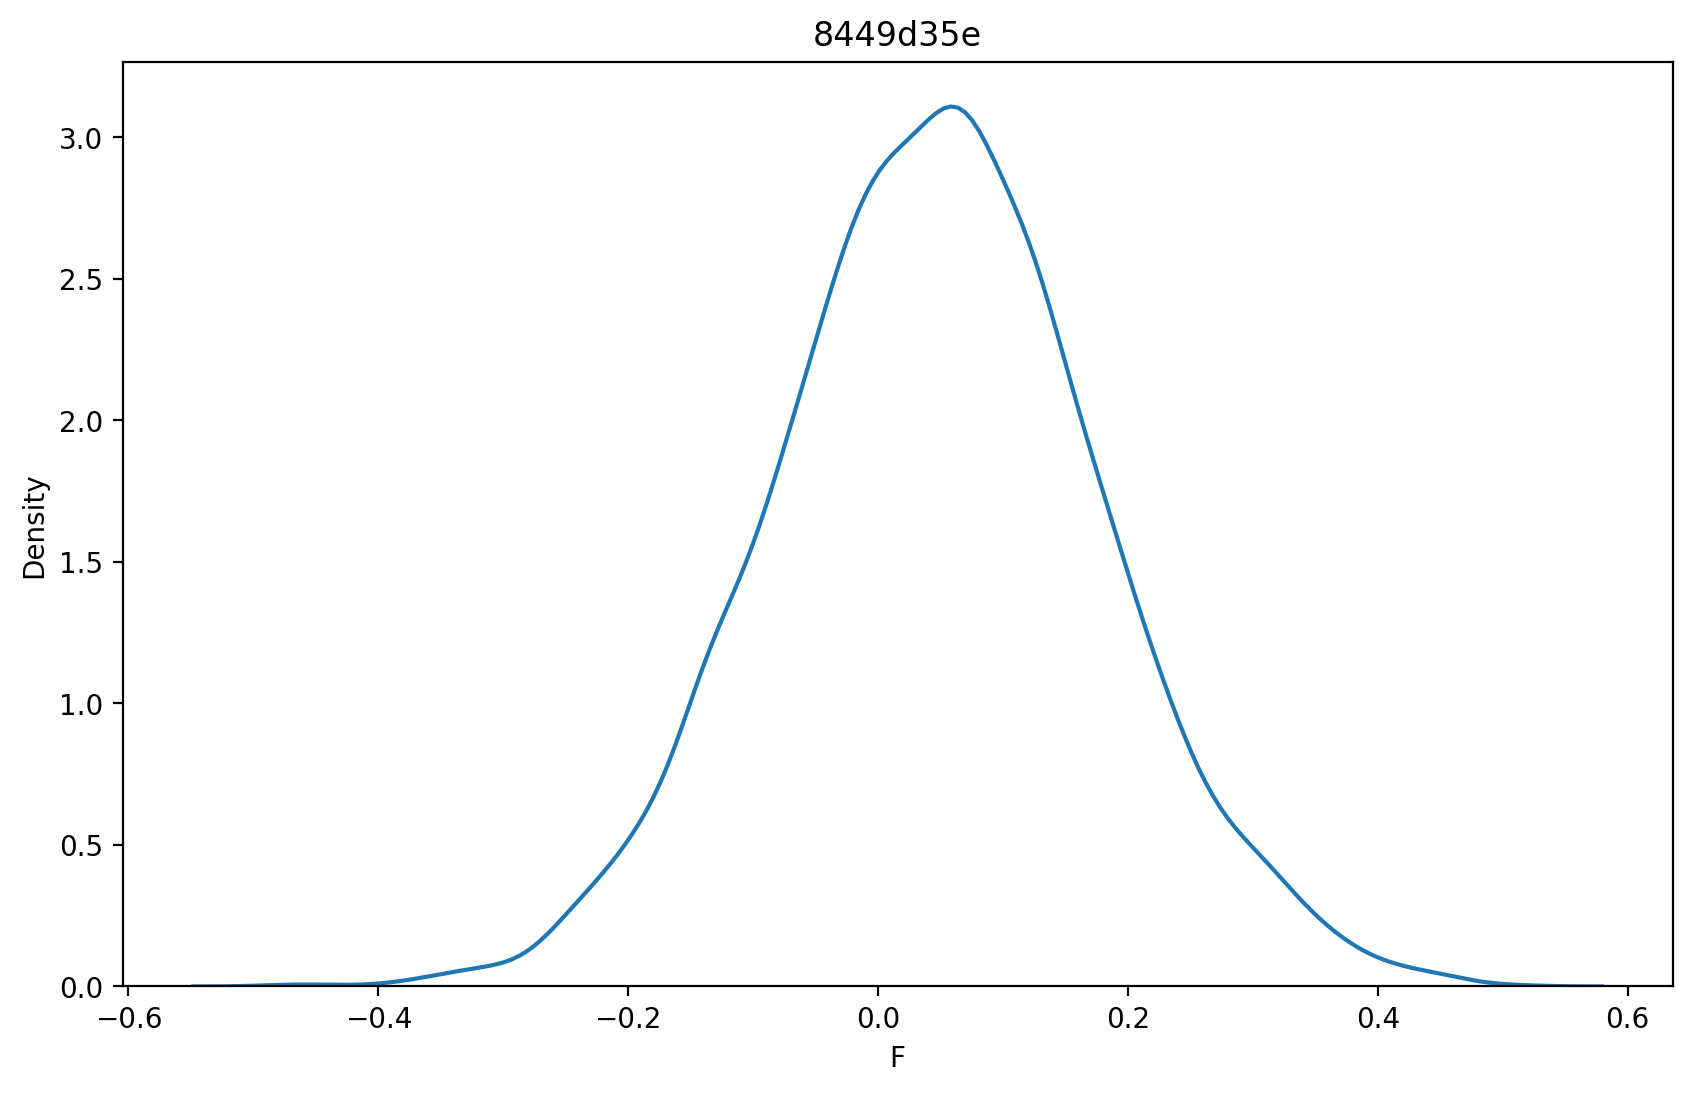

In [47]:
sns.kdeplot(idata.posterior.F.sel(player_ids=player_id).data.flatten())
plt.xlabel("F")
plt.title(player_id);